In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

from FirstPriceAuction import FirstPriceAuction 
from FFMultiplicativePacingAgent import FFMultiplicativePacingAgent 

In [2]:
n_advertisers = 4 
ctrs = np.ones(n_advertisers)
my_valuation = 0.6
B = 150

# environmental settings
days = 100
auctions_per_day = 5
T = days * auctions_per_day

eta = 1/np.sqrt(T)
rho = B/T

In [3]:
def discretize(T):
    epsilon = T**(-0.33)
    K = int(1/epsilon)
    return K

In [4]:
K = discretize(T)

# Highly Non-Stationary Bids

In [5]:
def bids_generator(n, T, plot = True, step = 20):
    other_bids = np.zeros((n, T))
    
    for idx in range(0, T, step):
        avg = np.random.uniform(0.2, 0.8, 1) 
        
        end_idx = min(idx+step, T)
        other_bids[:, idx:end_idx] = np.random.uniform(avg-0.2, avg+0.2, (n, end_idx-idx))
    
    if plot:
        plt.figure(figsize=(10, 6))
        for i in range(n):
            plt.plot(range(T), other_bids[i, :], label=f'Advertiser {i}')
        plt.xlabel('Time')
        plt.ylabel('Bids')
        plt.legend()
        plt.show()
    
    return other_bids

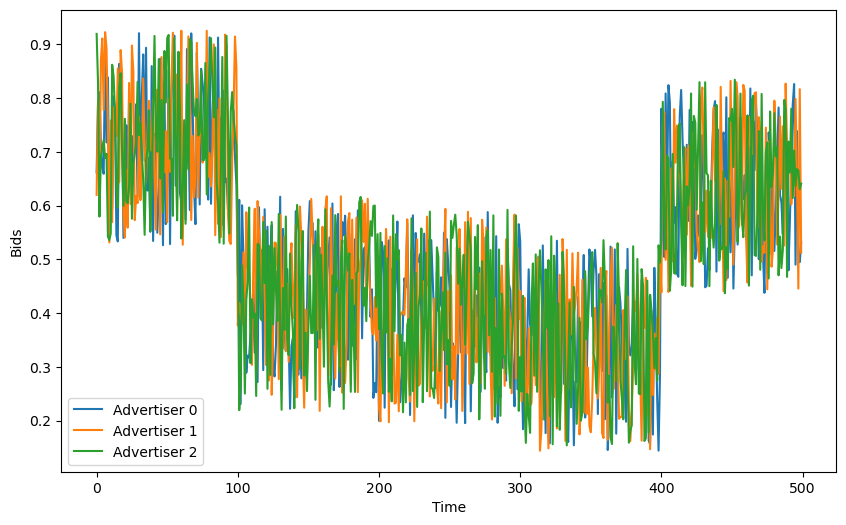

In [6]:
other_bids = bids_generator(n_advertisers - 1 , T, step = 100)

# Clairvoyant Bids

In [7]:
def clairvoyant(n, T, val, rho, K, other_bids, step=20):
    expected_clairvoyant_utilities = []
    expected_clairvoyant_bids = []
    
    for idx in range(0, T, step):
        available_bids = np.linspace(0, 1, K)
        
        end_idx = min(idx + step, T)
        win_probabilities = np.zeros(K)
        for bid_idx in range(K):
            bid = available_bids[bid_idx]
            win_probabilities[bid_idx] = np.mean(bid > other_bids[:, idx:end_idx])
        
        c = -(val - available_bids) * win_probabilities
        A_ub = [available_bids * win_probabilities]
        b_ub = [rho]
        A_eq = [np.ones(len(available_bids))]
        b_eq = [1]
        
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))
        gamma = res.x
        
        expected_clairvoyant_utilities += [-res.fun] * (end_idx - idx)
        expected_clairvoyant_bids += [sum(available_bids * gamma * win_probabilities)] * (end_idx - idx)
    
    return expected_clairvoyant_bids, expected_clairvoyant_utilities

In [8]:
expected_clairvoyant_bids, expected_clairvoyant_utilities = clairvoyant(n_advertisers, T, my_valuation, rho, K, other_bids, step = 100)

# Main

In [9]:
n_epochs = 50

all_regrets = []
all_payments = []

m_t = other_bids.max(axis=0)

for i in range(n_epochs):
    agent = FFMultiplicativePacingAgent(K = K, 
                                        valuation=my_valuation,
                                        budget=B,
                                        T=T, 
                                        eta=eta)

    auction = FirstPriceAuction(ctrs)
    utilities = np.array([])
    my_bids = np.array([])
    my_payments = np.array([])

    np.random.seed(i)
    for u in range(T):
        # interaction
        my_bid = agent.bid()
        bids = np.append(my_bid, other_bids[:, u].ravel())
        winners, payments_per_click = auction.round(bids=bids)
        my_win = int(winners==0)
        f_t, c_t = (my_valuation-m_t[u])*my_win, m_t[u]*my_win
        agent.update(f_t, c_t, m_t[u])
        # logging
        utilities = np.append(utilities, f_t)
        my_payments = np.append(my_payments, c_t)
    all_regrets.append(np.cumsum(expected_clairvoyant_utilities-utilities))
    all_payments.append(np.cumsum(my_payments))

avg_regret = np.array(all_regrets).mean(axis=0)
std_regret = np.array(all_regrets).std(axis=0)

avg_payments = np.array(all_payments).mean(axis=0)
std_payments = np.array(all_payments).std(axis=0)

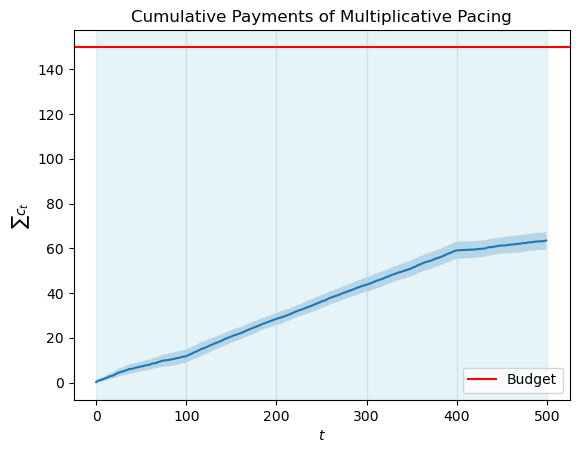

In [10]:
plt.plot(np.arange(T), avg_payments)
plt.fill_between(np.arange(T), avg_payments-std_payments, avg_payments+std_payments, alpha=0.3)
for i in range(0, T, 100):
    plt.axvspan(i, i + 100, color='lightblue', alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

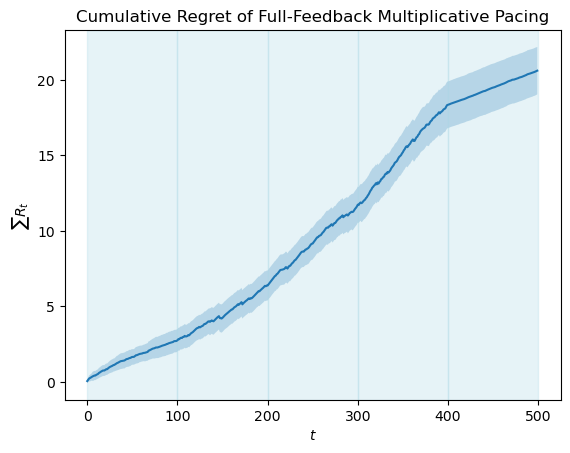

In [11]:
plt.plot(np.arange(T), avg_regret)
plt.fill_between(np.arange(T), avg_regret-std_regret, avg_regret+std_regret, alpha=0.3)
for i in range(0, T, 100):
    plt.axvspan(i, i + 100, color='lightblue', alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Full-Feedback Multiplicative Pacing')
plt.show()